# Implement MLP using Pytorch

Implement MLP(Multi Layer Perceptron) using Pytorch. Classify Fashion-MNIST dataset.
Process is as below.
- 1) Address Fashon-MNIST dataset
- 2) Data loading
- 3) Multilayer Perceptron Model
- 4) Training
- 5) Evaluation
- 6) Discussion

In [2]:
import torch
import os
import numpy as np
import time
import random
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
# Document: https://pytorch.org/docs/stable/nn.functional.html
import matplotlib.pyplot as plt
# Document: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.html
%matplotlib inline

In [3]:
RANDOM_SEED = 123
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## 1) Dataset 설명

이 데이터셋은 기존의 MNIST와 비슷하게 10개의 클래스로 이루어진 데이터셋입니다. 또한 흑백의 28x28크기, 60k개의 학습용 이미지와 10k개의 테스트용 이미지로 구성 되어 있는것과 같이 MNIST와 대부분 비슷한 구조로 이뤄져 있습니다. 

아래는 데이터셋의 샘플 이미지 입니다.

![](https://github.com/zalandoresearch/fashion-mnist/raw/master/doc/img/fashion-mnist-sprite.png)

출처: https://github.com/zalandoresearch/fashion-mnist)



데이터셋의 10개의 클래스는 다음과 같습니다.


| Label | Description |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

## 2) Dataset Loader

In [5]:
import torch
from PIL import Image
from torchvision.datasets import FashionMNIST
from torchvision import transforms
from torch.utils.data import DataLoader

import os

In [12]:
# Train 데이터 로딩시 이미지 데이터 전처리를 Transforms를 통해 할 수 있습니다.
# ToTensor는 PIL 형태의 이미지나 ndarray 를 PyTorch 가 이해할 수 있는 tensor 자료형으로 바꾸어 주는 역할을 하며
# Random Flip, Random Crop 등을 사용하여 Data augmentation을 수행하고 이를 통해 좋은 성능을 얻을 수 있습니다.
# 하지만, 이번에는 사용하지 않습니다.
# Document: https://pytorch.org/vision/stable/transforms.html
custom_train_transform = transforms.Compose([  
                                             transforms.ToTensor(),
                                             transforms.Normalize(mean=(0.5,), std=(0.5,))
])

In [13]:
# Test 데이터 로딩시 데이터 Transform
# Testset의 Trainsform은 Training set 과 다르게 랜덤하게 변경되면 안됩니다.
# 이번엔 사용하지 않습니다.
custom_test_transform = transforms.Compose([
                                             transforms.ToTensor(),
                                             transforms.Normalize(mean=(0.5,), std=(0.5,))
])

In [15]:

BATCH_SIZE = 64 # 60000을 사용하면 Full-Batch 학습

In [16]:
train_dataset = FashionMNIST(".", train=True, download=True, transform=custom_train_transform)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          drop_last=True,
                          num_workers=2)


test_dataset = FashionMNIST(".", train=False, download=True, transform=custom_test_transform)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=2)

아래 셀은 데이터셋이 잘 Load 되었는지 확인하는 테스트용 코드입니다.

In [17]:
num_epochs = 2
for epoch in range(num_epochs):

    for batch_idx, (x, y) in enumerate(train_loader):
        
        print('Epoch:', epoch+1, end='')
        print(' | Batch index:', batch_idx, end='')
        print(' | Batch size:', y.size()[0])
        
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        
        print('break minibatch for-loop')
        break

Epoch: 1 | Batch index: 0 | Batch size: 64
break minibatch for-loop
Epoch: 2 | Batch index: 0 | Batch size: 64
break minibatch for-loop


## 3) Multilayer Perceptron Model

아래 셀은 MLP모델을 정의하는 부분입니다. 이 과제에서 메인 부분입니다.<br>
Hidden layer이 2개가 되도록 변경하세요. 필요에 따라 3개 이상으로 늘려도 됩니다.

In [19]:
############################################################
# 변경 가능한 셀
############################################################

class MLP(torch.nn.Module):

    def __init__(self, num_features, num_hidden_1, num_hidden_2, num_classes):
        super(MLP, self).__init__()
        
        self.num_classes = num_classes
        
        ### 레이어 수 추가
        self.linear_1 = torch.nn.Linear(num_features, num_hidden_1)
        self.linear_2 = torch.nn.Linear(num_hidden_1, num_hidden_2)
        #self.linear_3 = torch.nn.Linear(num_hidden_2, num_hidden_3)
        self.linear_out = torch.nn.Linear(num_hidden_2, num_classes)
        
    def forward(self, x):
        
        ### activation 함수 변경 가능
        ### 레이어간의 연결 추가, 변경
        out1 = self.linear_1(x)
        out1 = torch.relu(out1)
        
        
        # <your code> to set the layer and the activation function
        out2 = self.linear_2(out1)
        out2 = torch.relu(out2)
        
#         out3 = self.linear_3(out2)
#         out3 = torch.tanh(out3)
        
        logits = self.linear_out(out2)
        probas = torch.relu(logits)
        return logits, probas

    
#################################
### Model 초기화
#################################

# random seed는 무작위 가중치 초기화가 항상 같도록 해줍니다.
# 초기화된 가중치에 따라 같은 네트워크도 서로 다른 성능을 낼 수 있어서 
# 실제 사용시에는 좋은 성능을 얻기 위해 여러가지 무작위 가중치를 시도해 볼 수 있습니다.
# 그러나 여기서는 변경하지 않습니다.
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# No. of hidden unit is recommended [input_unit/2 + output_unit]
# reference : https://kugancity.tistory.com/entry/MLP%EC%97%90%EC%84%9C-%EC%A0%81%EC%A0%88%ED%95%9C-hidden-unit-%EA%B0%9C%EC%88%98-%EC%82%B0%EC%A0%95%ED%95%98%EA%B8%B0 

model = MLP(num_features=28*28,
            num_hidden_1=402,
            num_hidden_2=402,
            #num_hidden_3=10,
            num_classes=10)

model = model.to(DEVICE)

## 4) Training

In [20]:
### Optimizer는 가중치를 업데이트하는 방법을 바꾸어 더 빠르게 좋은 성능을 낼 수 있도록합니다.
### 이 과제에서는 optimizer를 변경하지 않고, Learning Rate(lr)만 변경합니다.
optimizer = torch.optim.SGD(model.parameters(), lr=0.25)
############################################################

In [21]:
NUM_EPOCHS = 15 # 변경하며 값 측정
############################################################

In [22]:
def compute_accuracy_and_loss(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    cross_entropy = 0.
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.view(-1, 28*28).to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        cross_entropy += F.cross_entropy(logits, targets).item()
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100, cross_entropy/num_examples
    

start_time = time.time()
train_acc_lst, test_acc_lst = [], []
train_loss_lst, test_loss_lst = [], []

for epoch in range(NUM_EPOCHS):
    
    model.train()
    
    for batch_idx, (features, targets) in enumerate(train_loader):
    
        ### PREPARE MINIBATCH
        features = features.view(-1, 28*28).to(DEVICE)
        targets = targets.to(DEVICE)
            
        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 40:
            print (f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} | '
                   f'Batch {batch_idx:03d}/{len(train_loader):03d} |' 
                   f' Cost: {cost:.4f}')

    # no need to build the computation graph for backprop when computing accuracy
    model.eval()
    with torch.set_grad_enabled(False):
        train_acc, train_loss = compute_accuracy_and_loss(model, train_loader, device=DEVICE)
        test_acc, test_loss = compute_accuracy_and_loss(model, test_loader, device=DEVICE)
        train_acc_lst.append(train_acc)
        test_acc_lst.append(test_acc)
        train_loss_lst.append(train_loss)
        test_loss_lst.append(test_loss)
        print(f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} Train Acc.: {train_acc:.2f}%'
              f' | Test Acc.: {test_acc:.2f}%')
        
    elapsed = (time.time() - start_time)/60
    print(f'Time elapsed: {elapsed:.2f} min')
  
elapsed = (time.time() - start_time)/60
print(f'Total Training Time: {elapsed:.2f} min')

Epoch: 001/015 | Batch 000/937 | Cost: 2.2987
Epoch: 001/015 | Batch 040/937 | Cost: 0.7263
Epoch: 001/015 | Batch 080/937 | Cost: 0.6933
Epoch: 001/015 | Batch 120/937 | Cost: 0.8002
Epoch: 001/015 | Batch 160/937 | Cost: 0.7114
Epoch: 001/015 | Batch 200/937 | Cost: 0.4707
Epoch: 001/015 | Batch 240/937 | Cost: 0.6329
Epoch: 001/015 | Batch 280/937 | Cost: 0.4931
Epoch: 001/015 | Batch 320/937 | Cost: 0.6853
Epoch: 001/015 | Batch 360/937 | Cost: 0.3754
Epoch: 001/015 | Batch 400/937 | Cost: 0.4310
Epoch: 001/015 | Batch 440/937 | Cost: 0.4782
Epoch: 001/015 | Batch 480/937 | Cost: 0.2867
Epoch: 001/015 | Batch 520/937 | Cost: 0.4962
Epoch: 001/015 | Batch 560/937 | Cost: 0.4257
Epoch: 001/015 | Batch 600/937 | Cost: 0.5546
Epoch: 001/015 | Batch 640/937 | Cost: 0.4949
Epoch: 001/015 | Batch 680/937 | Cost: 0.4935
Epoch: 001/015 | Batch 720/937 | Cost: 0.2857
Epoch: 001/015 | Batch 760/937 | Cost: 0.6023
Epoch: 001/015 | Batch 800/937 | Cost: 0.3781
Epoch: 001/015 | Batch 840/937 | C

Epoch: 008/015 | Batch 000/937 | Cost: 0.1821
Epoch: 008/015 | Batch 040/937 | Cost: 0.2284
Epoch: 008/015 | Batch 080/937 | Cost: 0.2187
Epoch: 008/015 | Batch 120/937 | Cost: 0.2414
Epoch: 008/015 | Batch 160/937 | Cost: 0.2757
Epoch: 008/015 | Batch 200/937 | Cost: 0.3154
Epoch: 008/015 | Batch 240/937 | Cost: 0.2217
Epoch: 008/015 | Batch 280/937 | Cost: 0.1137
Epoch: 008/015 | Batch 320/937 | Cost: 0.2452
Epoch: 008/015 | Batch 360/937 | Cost: 0.2428
Epoch: 008/015 | Batch 400/937 | Cost: 0.2349
Epoch: 008/015 | Batch 440/937 | Cost: 0.1862
Epoch: 008/015 | Batch 480/937 | Cost: 0.2398
Epoch: 008/015 | Batch 520/937 | Cost: 0.2799
Epoch: 008/015 | Batch 560/937 | Cost: 0.2252
Epoch: 008/015 | Batch 600/937 | Cost: 0.3047
Epoch: 008/015 | Batch 640/937 | Cost: 0.2434
Epoch: 008/015 | Batch 680/937 | Cost: 0.0962
Epoch: 008/015 | Batch 720/937 | Cost: 0.1956
Epoch: 008/015 | Batch 760/937 | Cost: 0.2705
Epoch: 008/015 | Batch 800/937 | Cost: 0.1648
Epoch: 008/015 | Batch 840/937 | C

Epoch: 015/015 | Batch 000/937 | Cost: 0.1194
Epoch: 015/015 | Batch 040/937 | Cost: 0.1591
Epoch: 015/015 | Batch 080/937 | Cost: 0.0909
Epoch: 015/015 | Batch 120/937 | Cost: 0.0978
Epoch: 015/015 | Batch 160/937 | Cost: 0.2662
Epoch: 015/015 | Batch 200/937 | Cost: 0.2607
Epoch: 015/015 | Batch 240/937 | Cost: 0.2195
Epoch: 015/015 | Batch 280/937 | Cost: 0.3351
Epoch: 015/015 | Batch 320/937 | Cost: 0.1523
Epoch: 015/015 | Batch 360/937 | Cost: 0.0851
Epoch: 015/015 | Batch 400/937 | Cost: 0.1498
Epoch: 015/015 | Batch 440/937 | Cost: 0.1968
Epoch: 015/015 | Batch 480/937 | Cost: 0.3120
Epoch: 015/015 | Batch 520/937 | Cost: 0.0514
Epoch: 015/015 | Batch 560/937 | Cost: 0.3202
Epoch: 015/015 | Batch 600/937 | Cost: 0.2571
Epoch: 015/015 | Batch 640/937 | Cost: 0.0947
Epoch: 015/015 | Batch 680/937 | Cost: 0.1480
Epoch: 015/015 | Batch 720/937 | Cost: 0.1990
Epoch: 015/015 | Batch 760/937 | Cost: 0.0838
Epoch: 015/015 | Batch 800/937 | Cost: 0.1654
Epoch: 015/015 | Batch 840/937 | C

## 5) Evaluation

테스트 데이터와 학습 데이터의 Loss변화를 확인합니다.

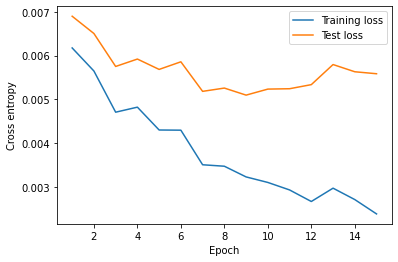

In [23]:
plt.plot(range(1, NUM_EPOCHS+1), train_loss_lst, label='Training loss')
plt.plot(range(1, NUM_EPOCHS+1), test_loss_lst, label='Test loss')
plt.legend(loc='upper right')
plt.ylabel('Cross entropy')
plt.xlabel('Epoch')
plt.show()

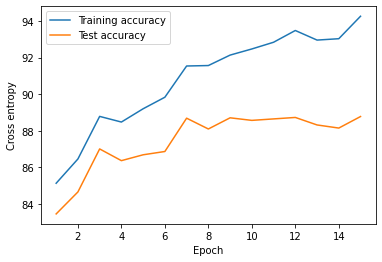

In [24]:
plt.plot(range(1, NUM_EPOCHS+1), train_acc_lst, label='Training accuracy')
plt.plot(range(1, NUM_EPOCHS+1), test_acc_lst, label='Test accuracy')
plt.legend(loc='upper left')
plt.ylabel('Cross entropy')
plt.xlabel('Epoch')
plt.show()

In [25]:
model.eval()
with torch.set_grad_enabled(False): # save memory during inference
    test_acc, test_loss = compute_accuracy_and_loss(model, test_loader, DEVICE)
    print(f'Test accuracy: {test_acc:.2f}%')

Test accuracy: 88.78%


- Training:  94.26%
- Test 88.78%